In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install transformers datasets rouge-score
! pip install transformers[torch]
! pip install accelerate -U
! pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=0b6225a733fa2a150ce06818b4267cc3ffdde002d04750d71c22a7b459ff18ee
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from rouge import Rouge
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
max_article_length = 500
max_summary_length = 50

In [ ]:
def process_data_to_model_inputs(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=max_article_length)
    outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=max_summary_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = outputs.input_ids

    return batch

In [ ]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
train_data = dataset['train']
train_df = pd.DataFrame(train_data)

In [ ]:
validation_data = dataset['validation']
validation_df = pd.DataFrame(validation_data)

In [ ]:
test_data = dataset['test']
test_df = pd.DataFrame(test_data)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
train_dataset = train_dataset.map(process_data_to_model_inputs, batched=True)
val_dataset = val_dataset.map(process_data_to_model_inputs, batched=True)
test_dataset = test_dataset.map(process_data_to_model_inputs, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/t5_transfer_learning/results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/t5_transfer_learning/logs",
    logging_steps=1,
    logging_first_step=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [19]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,2.543500,1.413106


FailedPreconditionError: ignored

In [32]:
import glob

# Get the latest checkpoint
checkpoints = list(glob.glob(f"{training_args.output_dir}/checkpoint-*"))
latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("-")[-1]))

# Load the latest checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(latest_checkpoint)

# Continue training from the latest checkpoint
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
2,2.154500,1.401886
3,0.538800,1.406090


TrainOutput(global_step=215337, training_loss=0.9058779565080118, metrics={'train_runtime': 23380.0033, 'train_samples_per_second': 36.841, 'train_steps_per_second': 9.21, 'total_flos': 5.1222576220416e+17, 'train_loss': 0.9058779565080118, 'epoch': 3.0})

In [33]:
# Extract training and evaluation losses from log history
training_losses = [log.get('loss', None) for log in trainer.state.log_history]
eval_losses = [log.get('eval_loss', None) for log in trainer.state.log_history]

# Remove None values
training_losses = [loss for loss in training_losses if loss is not None]
eval_losses = [loss for loss in eval_losses if loss is not None]

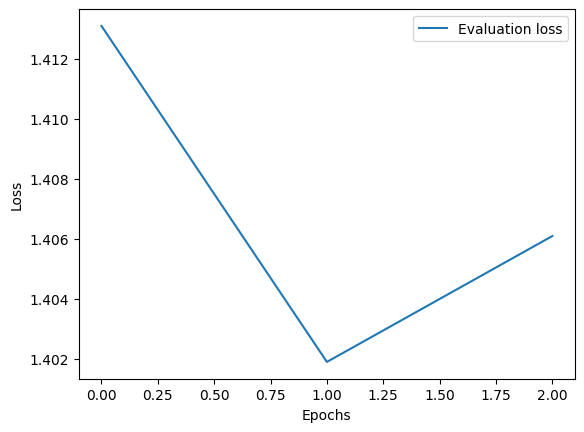

In [34]:
# Plot the losses
plt.plot(eval_losses, label='Evaluation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

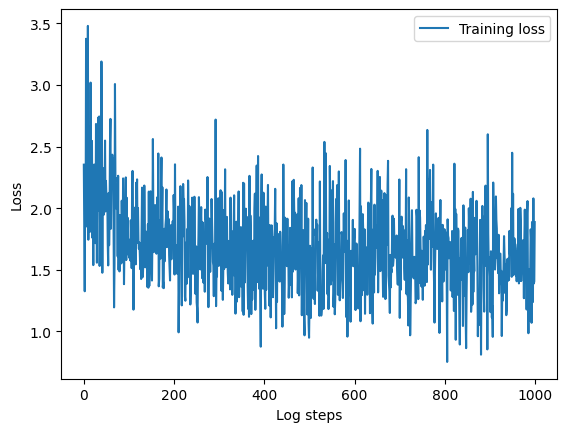

In [39]:
plt.plot(training_losses[:1000], label='Training loss')
plt.xlabel('Log steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
trainer.save_model("/content/drive/MyDrive/t5_transfer_learning/model")